In [31]:
# Import Libraries
%matplotlib inline
import s3fs
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from bs4 import BeautifulSoup
import lxml
import requests
from selenium import webdriver
import pandas as pd
import urllib.request
import geocoder
import geopandas as gpd
import geopy
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors
from io import StringIO
import psycopg2.extras 
import sqlalchemy
import os
import time
import memory_profiler
from memory_profiler import memory_usage
from config_user_dta import config
from typing import Iterator, Optional, Dict, Any,List
import io



from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [32]:
#Read the file from AWS bucket
calendar_df=pd.read_csv("s3://scy-uoft-group1-airbnb/calendar.csv.gz", storage_options={"anon":True},)
calendar_df.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,1419,2022-06-06,f,$469.00,$469.00,28.0,730.0
1,1419,2022-06-07,f,$469.00,$469.00,28.0,730.0
2,1419,2022-06-08,f,$469.00,$469.00,28.0,730.0
3,1419,2022-06-09,f,$469.00,$469.00,28.0,730.0
4,1419,2022-06-10,f,$469.00,$469.00,28.0,730.0


In [33]:
#Show the null values
calendar_df.isnull().sum()

listing_id        0
date              0
available         0
price             2
adjusted_price    2
minimum_nights    2
maximum_nights    2
dtype: int64

In [34]:
# Drop rows with nulls
calendar_df.dropna(how="any",inplace=True)

In [14]:
#Format the price column
calendar_df["price"]=calendar_df["price"].str.replace("$","").str.replace(",","").astype(float)
calendar_df["price"]=calendar_df["price"].map("{:.0f}".format).astype(float)

C:\Users\SUKANYA GHOSH\AppData\Local\Temp\ipykernel_4752\1877867407.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  calendar_df["price"]=calendar_df["price"].str.replace("$","").str.replace(",","").astype(float)


In [15]:
#Format date column to extract weekday and month
calendar_df['date']=pd.to_datetime(calendar_df.date)
calendar_df['weekday'] =calendar_df['date'].dt.day_name()
calendar_df['month'] =calendar_df['date'].dt.month_name()

## EDA and Visualization

Text(0.5, 1.0, 'Mean Price by Day of Week')

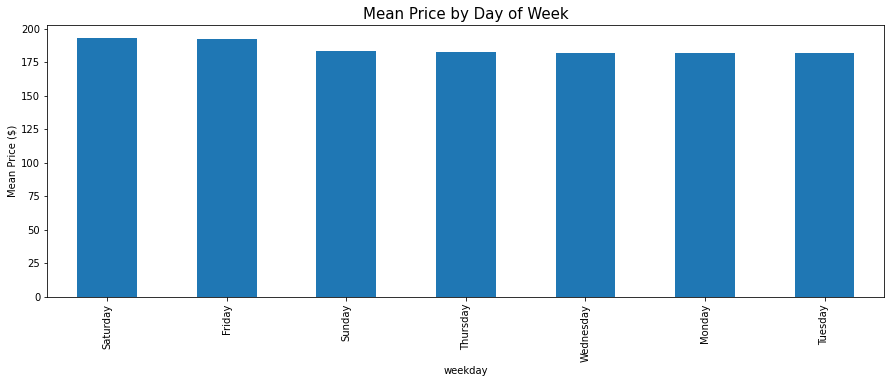

In [16]:
# Plot average price by day of week
weekday_price=calendar_df.groupby(["weekday"]).mean()["price"].sort_values(ascending=False)
weekday_price.plot(kind="bar", figsize=(15,5))
plt.ylabel("Mean Price ($)")
plt.title("Mean Price by Day of Week", fontsize=15)

Text(0.5, 1.0, 'Mean Price by Month')

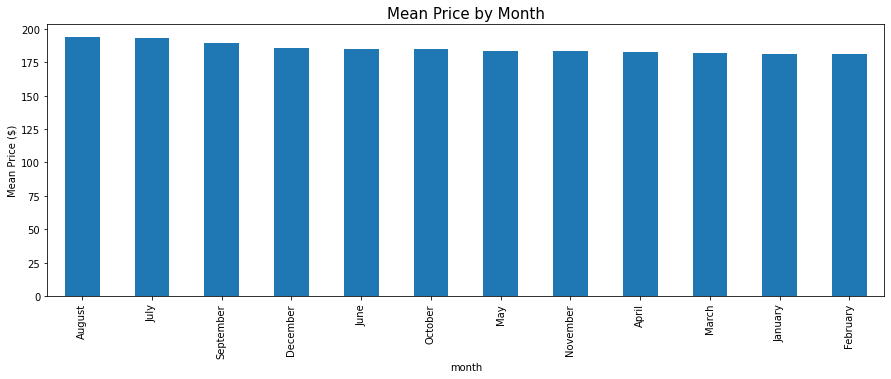

In [17]:
#Plot average price by month
month_price=calendar_df.groupby(["month"]).mean()["price"].sort_values(ascending=False)
month_price.plot(kind="bar", figsize=(15,5))
plt.ylabel("Mean Price ($)")
plt.title("Mean Price by Month", fontsize=15)

In [18]:
# Copy the clean data
clean_calendar_df=calendar_df.copy()

In [19]:
# Remove unwanted columns
clean_calendar_df.drop(columns=["adjusted_price","minimum_nights","maximum_nights"], inplace=True)

In [20]:
#Show dataframe
clean_calendar_df.head()

,listing_id,date,available,price,weekday,month
0,1419,2022-06-06,f,469.0,Monday,June
1,1419,2022-06-07,f,469.0,Tuesday,June
2,1419,2022-06-08,f,469.0,Wednesday,June
3,1419,2022-06-09,f,469.0,Thursday,June
4,1419,2022-06-10,f,469.0,Friday,June


In [21]:
#Format the listings id column for importing in PostgreSQL
clean_calendar_df["listing_id"]=clean_calendar_df["listing_id"].astype(str)

In [22]:
# Prepare the datatypes for database
replacements={
    "object": "varchar",
    "float64": "float",
    "int64": "int",
    "datetime64[ns]": "timestamp",
    'timedelta64[ns]': "varchar"
}

replacements

{'object': 'varchar',
 'float64': 'float',
 'int64': 'int',
 'datetime64[ns]': 'timestamp',
 'timedelta64[ns]': 'varchar'}

In [23]:
# Replace the datatype for columns in dataframe
col_str=",".join("{} {}".format(n,d) for (n,d) in zip(clean_calendar_df.columns, clean_calendar_df.dtypes.replace(replacements)))
col_str

'listing_id varchar,date timestamp,available varchar,price float,weekday varchar,month varchar'

## Insert Data into Database

In [24]:
# Get the config params
params_ = config()

# Connect to the Postgres_DB:
conn = psycopg2.connect(**params_)

# Create new_cursor allowing us to write Python to execute PSQL:
cur = conn.cursor()

conn.autocommit = True  # read documentation understanding when to Use & NOT use (TRUE)
print("opened database successfully")

opened database successfully


In [25]:
#drop tables with the same name
cur.execute("drop table if exists clean_calendar;")

In [26]:
#create table
cur.execute("create table calendar_clean\
(listing_id varchar,date timestamp,available varchar,price float,weekday varchar,month varchar)")

In [27]:
#Insert values into the table

#save df to csv
clean_calendar_df.to_csv('clean_calendar.csv', header=clean_calendar_df.columns, index=False, encoding='utf-8')

#open the csv file, save it as an object, and upload to db
my_file=open('clean_calendar.csv')
print("file opened in memory")

file opened in memory


In [28]:
#Upload to database
SQL_STATEMENT= """
COPY calendar_clean FROM STDIN WITH
    CSV
    HEADER
    DELIMITER AS ','
"""

cur.copy_expert(sql=SQL_STATEMENT, file=my_file)
print('file copied to db')

file copied to db
